# ARIMA Lab

Run in `py36` environment:
```
conda create -n py36 python=3.6 pandas numpy seaborn matplotlib scipy patsy statsmodels jupyter
```

### [Video Guide to this Lab](https://youtu.be/3Gw1E_BJU58)

## Objectives

1. Explain time series decomposition
1. Describe additive and multiplicative data
1. Stationarize data
1. Fit AR, MA, and ARIMA models on prepared data
1. Interpret model parameters and performance
1. Visualize trends and forecasts

# Introduction
We often refer to our input features in machine learning as "dimensions". On that note, there's a dimension that pervades almost everything we do and observe as humans. It's the fourth dimension we experience every waking moment: time. But time is quite unlike other data we capture, and often requires unique machine learning approaches. These models and approaches are fairly established in  R and a few other languages, but have more recently immigrated to Python.

In regession and classification, we use features (collected during a cross-sectional study/survey/measurement) to predict an outcome. The model and parameters represent part of the underlying relationship between features and outcome. But what if we run out of funds to cross-section (it's possible), or need to predict future outcomes for which the features aren't measurable or don't yet exist?

### Examples of time series data and modeling (constant time interval):
- Hedge fund prediction of stock and index movements
- Long and short-term weather forecasting
- Business budgeting and trend analysis
- Health vitals monitoring
- Traffic flows and logistic optimization modeling
- Can you think of others?

Time series data usually contains more than meets the eye, and can often be decomposed into trend, seasonal, and random fluctuation components.

![Decomposition](http://rstatistics.net/wp-content/uploads/2014/09/Multiplicative-Decomposition-of-Time-series.png)

- Trends
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend; it depends on your goals
- Seasonal Effects
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: twitter spikes when news happens are not seasonal; they aren't regular and predictable
- Random Fluctuations
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future
    
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- Additive
    - Data = Trend + Seasonal + Random
    - What we will be using for our modeling
- Multiplicative
    - Data = Trend x Seasonal x Random
    - As easy to fit as Additive if we take the log
        - log(Data) = log(Trend x Seasonal x Random)

We should use multiplicative models when the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. If our seasonality and fluctuations are stable, we likely have an additive model.

## Time Series Modeling Process

Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference or take the log of the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic, i.i.d)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|

## How to achieve and test for stationarity

- The mean of the series is not a function of time:
!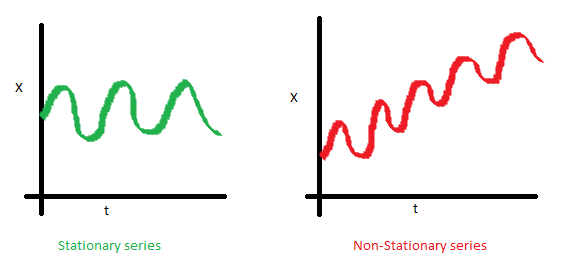

- The variance of the series is not a function of time (homoscedasticity):
![](data/Var_nonstationary.png)

- The covariance at different lags is not a function of time:
![](data/Cov_nonstationary.png)

[From A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

- [Info on stationarity](http://www.investopedia.com/articles/trading/07/stationary.asp)
- Plotting Rolling Statistics
    - Plot the moving average/variance and see if it changes with time. This visual technique can be done on different windows, but isn't as rigorously defensible as the test below.
- Dickey-Fuller Test
    - Statistical tests for checking stationarity; the null hypothesis is that the TS is non-stationary. If our test statistic is below an `alpha` value, we _can_ reject the null hypothesis and say that the series is stationary.
    
    $$ Y_t = \rho * Y_{t-1} + \epsilon_t $$
    
    $$ Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t $$

In [ ]:
# imports
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### How Differencing Works

In [ ]:
# create a play dataframe from 1-10 (linear and squared) to test how differencing works
play = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
play.columns = ['original', 'squared']
play

In [ ]:
# stationarize linear series (mean and variance doesn't change for sub-windows)
play.original.diff()
# this is similar to taking a first-order derivative

In [ ]:
# stationarize squared series
play.squared.diff().diff()
# notice we need to difference twice on an exponential trend, and every time we do, we lose a bit of data

In [ ]:
# stationarize squared with log
np.log(play.squared)
# somewhat works, not as dramatically

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [ ]:
# load data, recast columns if needed, convert to datetime
monthly_temp = pd.read_csv('./data/mean-monthly-temperature-1907-19.csv', skipfooter=2, 
                           infer_datetime_format=True, header=0, index_col=0, names=['month', 'temp'], engine='python')
#monthly_temp.temp = monthly_temp.temp.astype(float)
monthly_temp.index = pd.to_datetime(monthly_temp.index)

In [ ]:
monthly_temp.tail()

In [ ]:
# describe
monthly_temp.describe()

In [ ]:
# resample to annual and plot each
annual_temp = monthly_temp.resample('A').mean()
monthly_temp.plot();
annual_temp.plot();

In [ ]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp);
# note, easier to see trends on resampled or moving average charts

In [ ]:
# plot with plotly (optional): might need a plotly account and key
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Scatter(x=annual_temp.index, y=annual_temp.temp)]
py.iplot(data)

In [ ]:
# plot binned yearly segments using resample method
monthly_temp.resample('A').temp.plot();

In [ ]:
# violinplot months to determine variance and range
#sns.set()
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)
plt.xlabel("Month")
plt.ylabel("Farenheit Temperature");

Are these datasets stationary? We can look at a few things per the list above, including a visual check (there seems to be a small upward trend in the annual, too hard to tell for monthly), a standard deviation check on various differences (smallest one is usually most stationary), and the formal Dickey-Fuller test.

In [ ]:
# check montly deviations for various diffs
print(monthly_temp.temp.std())
print(monthly_temp.temp.diff().std())
print(monthly_temp.temp.diff().diff().std()) # theoretically lowest, but one above is close enough
print(monthly_temp.temp.diff().diff().diff().std())

In [ ]:
# check annual deviations for various diffs
print(annual_temp.temp.std()) # looks stationary as is
print(annual_temp.temp.diff().std())
print(annual_temp.temp.diff().diff().std())
print(annual_temp.temp.diff().diff().diff().std())

In [ ]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

In [ ]:
# run DFT on monthly
dftest(monthly_temp.temp)
# p-value allows us to reject a unit root: data is stationary

In [ ]:
# run DFT on annual
dftest(annual_temp.temp)
# p-value allows us to reject a unit root: data is stationary

# here's an example of non-stationary with DFT results
# dftest(np.exp(annual_temp.temp))

### NOTES

One of the key trading concepts in the quantitative toolbox is that of mean reversion. This process refers to a time series that displays a tendency to revert to its historical mean value. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. This is in contrast to a random walk (Brownian motion: discuss this on chess board!), which has no "memory" of where it has been at each particular instance of time. The mean-reverting property of a time series can be exploited in order to produce better predictions.

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

$$ dx_t=\theta(\mu - x_t)dt+\sigma dW_t $$
 
Where $\theta$
 is the rate of reversion to the mean, $\mu$
 is the mean value of the process, $\sigma$
 is the variance of the process and $W_t$
 is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing

## ARIMA with Statsmodels

Enter [Autoregressive Integrated Moving Average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) modeling. When we have autocorrelation between outcomes and their ancestors, we will see a theme, or relationship in the outcome plot. This relationship can be modeled in its own way, allowing us to predict the future with a confidence level commensurate to the strength of the relationship and the proximity to known values (prediction weakens the further out we go).

- [ARIMA in R](https://www.otexts.org/fpp/8/5)
- [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)
- [Great explanation on MA in practice](http://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)

### Autoregressive Models

![AR Model](./data/ar.svg)

Autocorrelation: a variable's correlation with itself at different lags.

For second-order stationary (both mean and variance: $\mu_t = \mu$ and $\sigma_t^2 = \sigma^2$ for all $t$) data, autocovariance is expressed as a function only of the time lag $k$:

$$ \gamma_k = E[(x_t-\mu)(x_{t+k} - \mu)] $$
  
Therefore, the autocorrelation function is defined as:

$$ \rho_k = \frac{\gamma_k}{\sigma^2} $$
  
We use the plot of these values at different lags to determine optimal ARIMA parameters. Notice how `phi` changes the process.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/ArTimeSeries.svg/685px-ArTimeSeries.svg.png)
By Tomaschwutz - Own work, CC BY 3.0, https://commons.wikimedia.org/w/index.php?curid=14740378


Some things to note:
1. AR models propagate shocks infinitely
1. Current random error is the `epsilon` error term
1. If a process depends on previous values of itself then it is an AR process. If it depends on previous errors than it is an MA process.
1. AR processes will exhibit exponential decay in ACR and a cut-off in PACR

### Moving Average Models (This is NOT a Simple/Weighted/Exponential Moving Average)

![MA Model](./data/ma.svg)

Some things to note:
1. MA models do not propagate shocks infinitely; they die after `q` lags
1. All previous errors up to a lag are rolled into the `epsilon` error term for that period
1. If a process depends on previous values of itself then it is an AR process. If it depends on previous errors than it is an MA process.
1. MA processes will exhibit exponential decay in PACR and a cut-off in ACR

### NOTES

Thus, a moving-average model is conceptually a linear regression of the current value of the series against current and previous (unobserved) white noise error terms or random shocks. The random shocks at each point are assumed to be mutually independent and to come from the same distribution, typically a normal distribution, with location at zero and constant scale.

Interpretation
The moving-average model is essentially a finite impulse response filter applied to white noise, with some additional interpretation placed on it. The role of the random shocks in the MA model differs from their role in the autoregressive (AR) model in two ways. First, they are propagated to future values of the time series directly: for example, 
ε
t
−
1
\varepsilon _{{t-1}} appears directly on the right side of the equation for 
X
t
X_{t}. In contrast, in an AR model 
ε
t
−
1
\varepsilon _{{t-1}} does not appear on the right side of the 
X
t
X_{t} equation, but it does appear on the right side of the 
X
t
−
1
X_{{t-1}} equation, and 
X
t
−
1
X_{{t-1}} appears on the right side of the 
X
t
X_{t} equation, giving only an indirect effect of 
ε
t
−
1
\varepsilon _{t-1} on 
X
t
X_{t}. Second, in the MA model a shock affects 
X
 X values only for the current period and q periods into the future; in contrast, in the AR model a shock affects 
X
 X values infinitely far into the future, because 
ε
t
\varepsilon _{t} affects 
X
t
X_{t}, which affects 
X
t
+
1
X_{{t+1}},etc.

https://en.wikipedia.org/wiki/Moving-average_model

-----------
Consider a series consisting of the closing price (adjusted for splits and dividends) of a stock on consecutive days. Each day's closing price is derived from a trend (e.g., linear in time) plus the weighted effects of the daily shocks from prior days. 

Presumably, the effect of the shock at day t-1 will have a stronger influence on the price at day t than will the shock at day t-2, etc. Thus, logically, the stock's closing price at day t will reflect the trend value on day t plus a constant (less than 1) times the weighted sum of the shocks up through day t-1 (i.e., the error term at day t-1)(MA1), possibly plus a constant (less than 1) times the weighted sum of the shocks up through day t-2 (i.e., the error term at day t-2)(MA2), ..., plus the novel shock at day t (white noise).

This kind of model seems appropriate for modelling series like the stock market, where the error term at day t represents the weighted sum of prior and current shocks, and defines an MA process.

https://stats.stackexchange.com/questions/107834/under-what-circumstances-is-an-ma-process-or-ar-process-appropriate

Many ways to predict future TS data, but SARIMA is performant. Other methods that we won't go into:
- Vector autoregressions (VARs)
- Gaussian state space models – often called structural time series or unobserved component models
- GARCH
- Generalized Autoregressive Score (GAS)
- Kalman Filters

### SARIMA
![SARIMA Form](./data/sarima.png)

### Create Helper Functions

In [ ]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [ ]:
# helper plot for monthly temps
plots(monthly_temp, lags=24);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [ ]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar.summary()

In [ ]:
# plot resids
plots(sar.resid, lags=40);

# Thought process: (Reference: https://people.duke.edu/~rnau/arimrule.htm)
# 010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
# we pick 000010,12 and Trend='c' per rule4/5

# now look at seasonal, notice negative ACR spike at 12: per rule 13, we add a SMA term
# big drop to 4284 AIC
# looks like ACR looks good at seasonal lags, so we move back to ARIMA portion

# rule6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC

In [ ]:
# plot residual diagnostics
sar.plot_diagnostics(figsize=(10, 8));

In [ ]:
# plot predictions
monthly_temp['forecast'] = sar.predict(start = 750, end= 820, dynamic=30)  
monthly_temp[730:][['temp', 'forecast']].plot();

# per the documentation, we start predicting at period 750, and start a dynamic forecast at 750 + 30
# this means we use our predictions as "ground truth" for following predictions

### Statistical Tests


- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is of no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [ ]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]
# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

### Note on autofit methods
R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. Over time, more of these goodies are porting to Python (e.g. statsmodels.tsa.x13 import x13_arima_select_order). While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

## Objectives

1. Explain time series decomposition
1. Describe additive and multiplicative data
1. Stationarize data
1. Fit AR, MA, and ARIMA models on prepared data
1. Interpret model parameters and performance
1. Visualize trends and forecasts

## Closing

- Which areas of time series modeling are most interesting?
- Which concepts are most challenging?
- How will you apply these concepts to your work or personal projects?
- Have you used other packages or tools that you've found helpful?

For more time series packages, check out the [Facebook Prophet](https://github.com/facebookincubator/prophet) and [Pyflux](http://www.pyflux.com) projects.